In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
import seaborn
from tensorflow.math import confusion_matrix
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Rescaling

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/tomatoleaf/tomato/cnn_train.py
/kaggle/input/tomatoleaf/tomato/val/Tomato___Late_blight/0db85707-41f9-42df-ba3b-842d14f00a68___GHLB2 Leaf 8909.JPG
/kaggle/input/tomatoleaf/tomato/val/Tomato___Late_blight/0fca6d09-1931-4767-a195-1dd2b7cd10b7___GHLB Leaf 8 Day 12.JPG
/kaggle/input/tomatoleaf/tomato/val/Tomato___Late_blight/Tomato___Late_blight_original_0ba7d3d8-5c4c-4365-ba0c-69f61e96a36e___RS_Late.B 5312.JPG_0c8b3e88-9afa-41e1-a767-122ad7b27ac2.JPG
/kaggle/input/tomatoleaf/tomato/val/Tomato___Late_blight/1b212ad6-e65a-4467-bfd1-9f9139070d33___GHLB2 Leaf 8609.JPG
/kaggle/input/tomatoleaf/tomato/val/Tomato___Late_blight/1d6d043a-9df9-49ec-9b0f-e40a8e7f409f___RS_Late.B 5287.JPG
/kaggle/input/tomatoleaf/tomato/val/Tomato___Late_blight/1d83eef4-92a0-42a2-9ea7-1ec2e683dbc0___GHLB2 Leaf 8809.JPG
/kaggle/input/tomatoleaf/tomato/val/Tomato___Late_blight/01ebf21e-ef94-4c92-b007-0b26741c2fc8___GHLB2 Leaf 9075.JPG
/kaggle/input/tomatoleaf/tomato/val/Tomato___Late_blight/1f38a263-cfb5-

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (256, 256)
IMG_WIDTH = 256
IMG_HEIGHT = 256
EPOCHS = 30

# **Data exploration**

In [ ]:
ds = image_dataset_from_directory(
    '/kaggle/input/tomatoleaf/tomato/train',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True
)
ds_val = image_dataset_from_directory(
    '/kaggle/input/tomatoleaf/tomato/val',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True
)

Found 10000 files belonging to 10 classes.
Found 1000 files belonging to 10 classes.


In [ ]:
ds.class_names, ds_val.class_names

(['Tomato___Bacterial_spot',
  'Tomato___Early_blight',
  'Tomato___Late_blight',
  'Tomato___Leaf_Mold',
  'Tomato___Septoria_leaf_spot',
  'Tomato___Spider_mites Two-spotted_spider_mite',
  'Tomato___Target_Spot',
  'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
  'Tomato___Tomato_mosaic_virus',
  'Tomato___healthy'],
 ['Tomato___Bacterial_spot',
  'Tomato___Early_blight',
  'Tomato___Late_blight',
  'Tomato___Leaf_Mold',
  'Tomato___Septoria_leaf_spot',
  'Tomato___Spider_mites Two-spotted_spider_mite',
  'Tomato___Target_Spot',
  'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
  'Tomato___Tomato_mosaic_virus',
  'Tomato___healthy'])

In [ ]:
len(ds)

313

# **Spliting Dataset to train and test**

In [ ]:
size = int(len(ds) * 0.8)
ds_train = ds.take(size)
ds_test = ds.skip(size)

In [ ]:
len(ds_train), len(ds_test), len(ds_val)

(250, 63, 32)

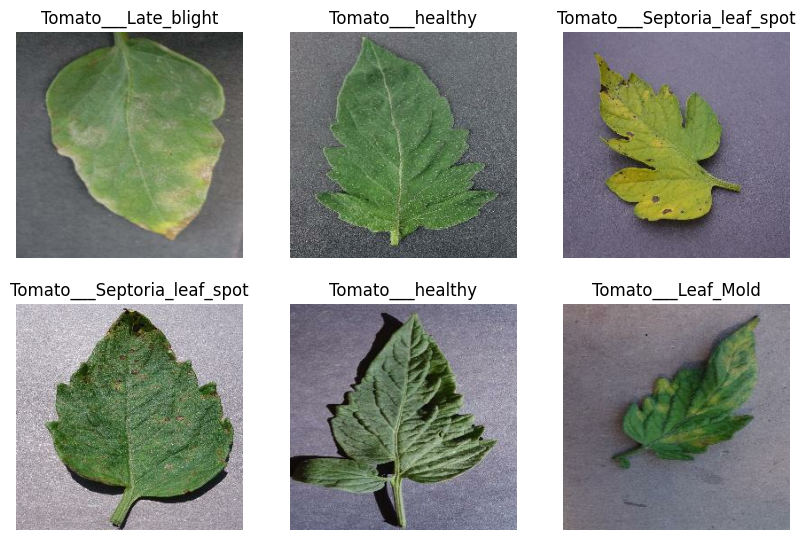

In [ ]:
plt.figure(figsize=(10, 10))
for img, label in ds_train.take(1):
    for i in range(6):
        plt.subplot(3, 3, i + 1)
        plt.imshow(img[i].numpy().astype('uint8'))
        plt.title(ds.class_names[label[i].numpy()])
        plt.axis('OFF')

# **Building Model From scratch**

In [ ]:
rescaler = Rescaling(scale=1./255, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
model = Sequential()
model.add(rescaler)
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 252, 252, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 126, 126, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 126, 126, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 124, 124, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 122, 122, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 61, 61, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 61, 61, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 238144)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    30,482,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,557,034 (116.57 MB)

 Trainable params: 30,557,034 (116.57 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer='Adam',
    metrics=['accuracy']
    )

In [ ]:
train_result = model.fit(
    ds_train,
    epochs=EPOCHS,
    validation_data=ds_val
)

Epoch 1/30


I0000 00:00:1728387284.257274     112 service.cc:145] XLA service 0x5adde29f26c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728387284.257340     112 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  3/250 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.0521 - loss: 2.9890

I0000 00:00:1728387294.969137     112 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


250/250 ━━━━━━━━━━━━━━━━━━━━ 32s 75ms/step - accuracy: 0.3036 - loss: 1.9423 - val_accuracy: 0.5260 - val_loss: 1.2974
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 62ms/step - accuracy: 0.6955 - loss: 0.8819 - val_accuracy: 0.6400 - val_loss: 1.0917
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.7899 - loss: 0.5942 - val_accuracy: 0.7770 - val_loss: 0.7043
Epoch 4/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.8737 - loss: 0.3697 - val_accuracy: 0.8020 - val_loss: 0.6169
Epoch 5/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9309 - loss: 0.2130 - val_accuracy: 0.7670 - val_loss: 0.9420
Epoch 6/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9517 - loss: 0.1455 - val_accuracy: 0.7760 - val_loss: 1.0591
Epoch 7/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9376 - loss: 0.1917 - val_accuracy: 0.7630 - val_loss: 1.3606
Epoch 8/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9531 - loss: 0.1535 - val_accurac

In [ ]:
train_loss = train_result.history['loss']
train_acc = train_result.history['accuracy']
val_loss = train_result.history['val_loss']
val_acc = train_result.history['val_accuracy']

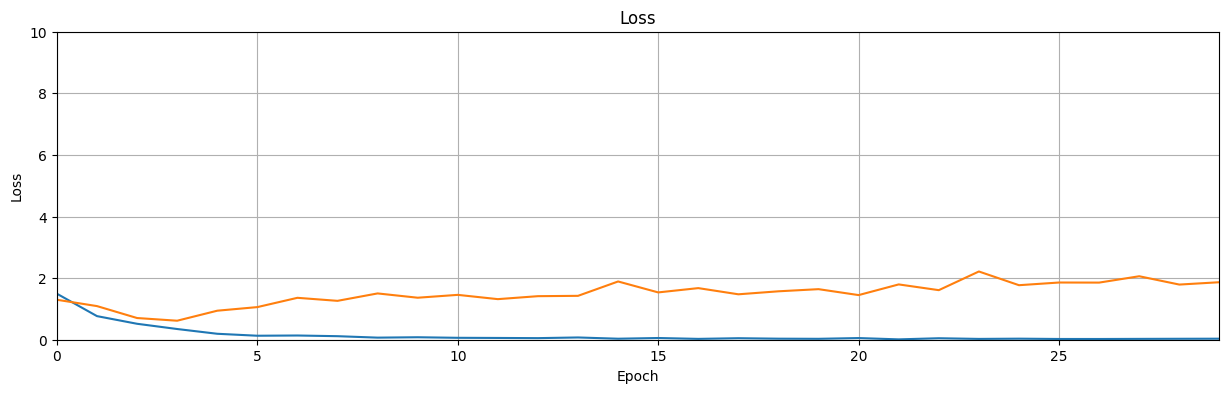

In [ ]:
fig, ax = plt.subplots(figsize=(15, 4))
for idx, metric in enumerate([train_loss, val_loss]):
  ax.plot(metric)

plt.title('Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xlim([0, EPOCHS - 1])
plt.ylim([0.0, 10.0])
plt.grid(True)

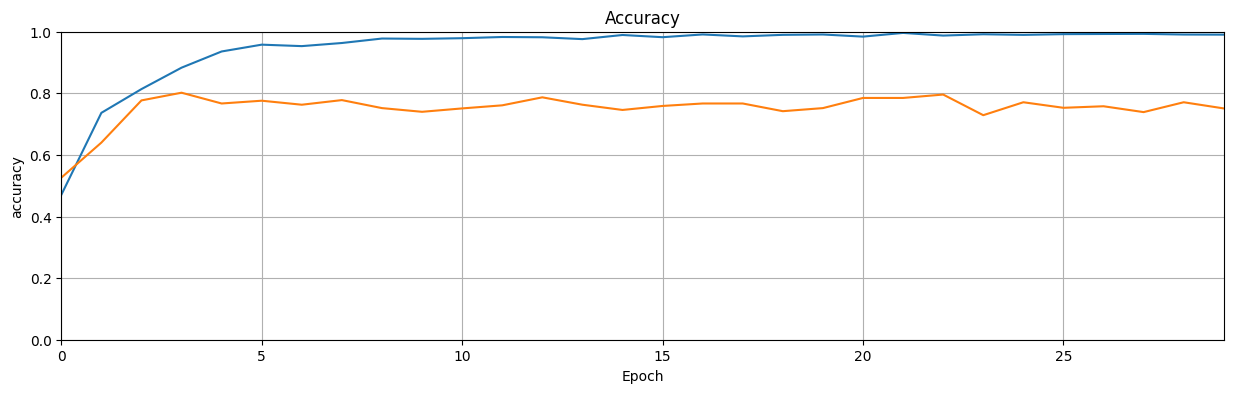

In [ ]:
fig, ax = plt.subplots(figsize=(15, 4))
for idx, metric in enumerate([train_acc, val_acc]):
  ax.plot(metric)
plt.title('Accuracy')
plt.xlabel("Epoch")
plt.ylabel("accuracy")
plt.xlim([0, EPOCHS - 1])
plt.ylim([0.0, 1.0])
plt.grid(True)

In [ ]:
model.evaluate(ds_test)

63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.8343 - loss: 1.0906


[1.3684215545654297, 0.796500027179718]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


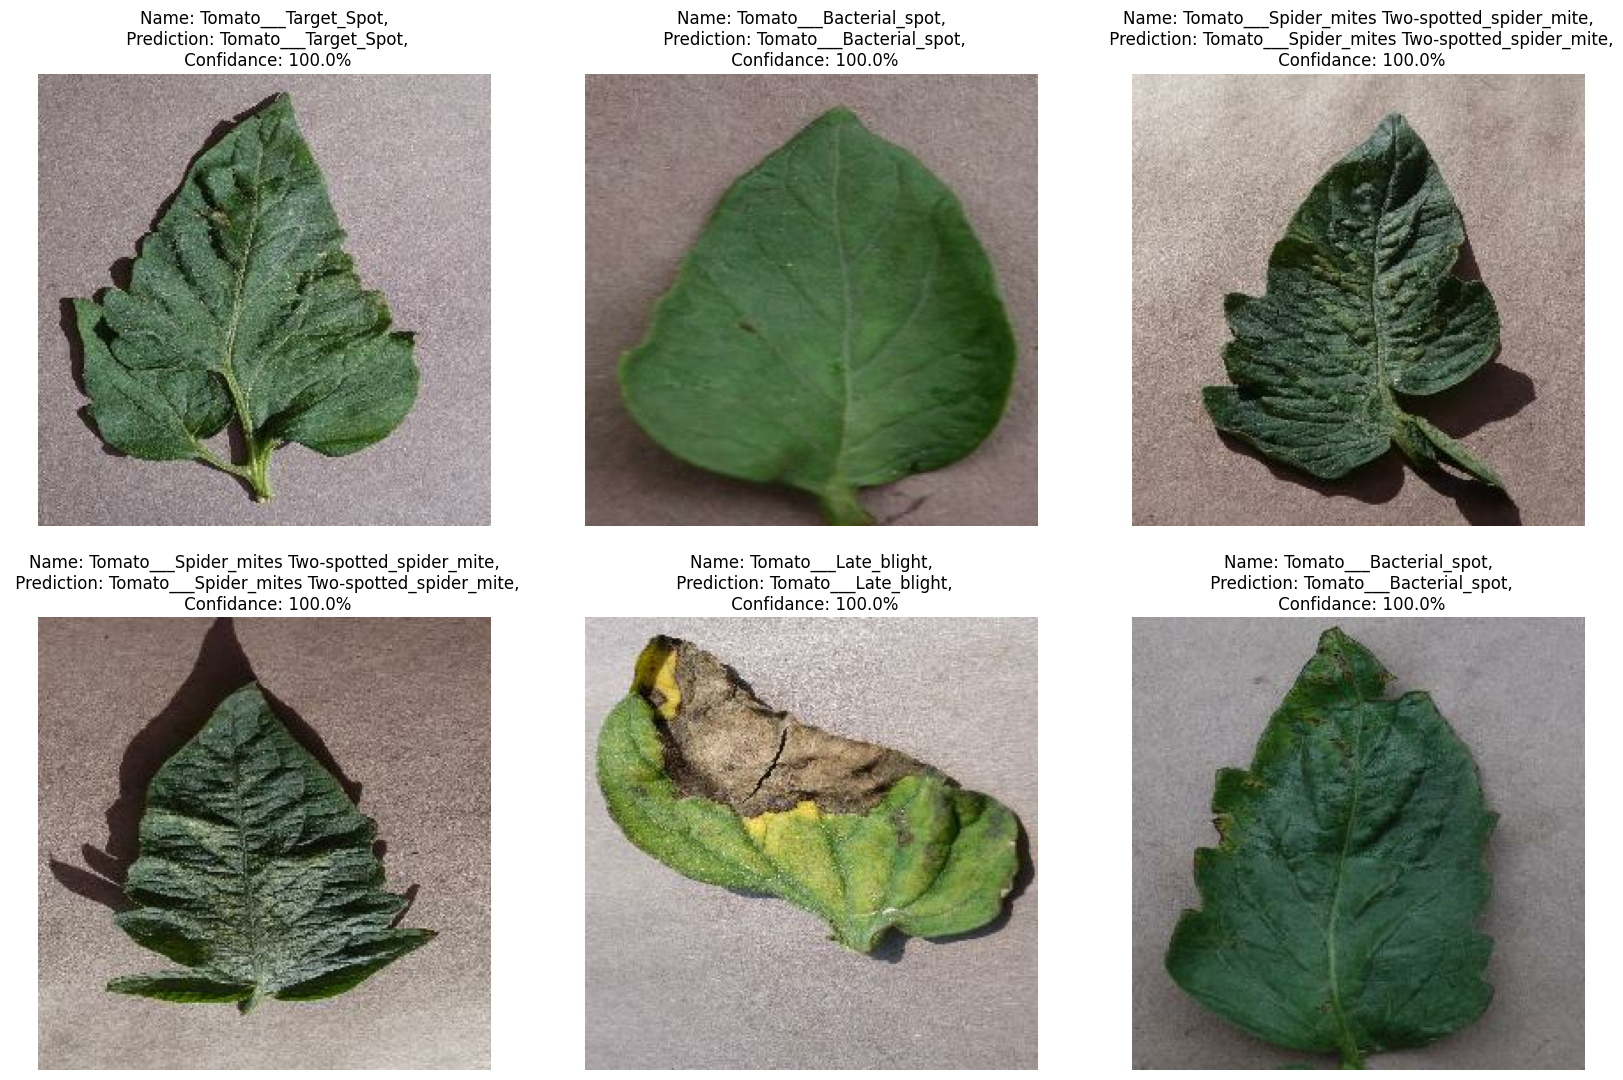

In [ ]:
plt.figure(figsize=(20, 20))
for img, label in ds_test.take(1):
    for i in range(6):
        plt.subplot(3, 3, i + 1)
        plt.imshow(img[i].numpy().astype('uint8'))
        pred = model.predict(img.numpy())
        confidance = round(np.max(pred[i]), 2)
        pred_name = ds.class_names[np.argmax(pred[i])]
        name = ds.class_names[label[i].numpy()]
        plt.title(f"Name: {name},\n Prediction: {pred_name},\n Confidance: {confidance * 100}%")
        plt.axis('OFF')

In [ ]:
model.export('TDD_v2')

Saved artifact at 'TDD_v2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  132144673746688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132144673451600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132144668202912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132144668205728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132144668544688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132144668545040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132144668547328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132144668549616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132144668689152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132144668691968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132144668697424: Tensor

In [ ]:
prediction = model.predict(ds_test)

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step


In [ ]:
len(ds_test)

63

In [ ]:
y_pred = []
y_true = []
for img, label in ds_test.take(2):
    for i in range(BATCH_SIZE):
        pred = model.predict(img.numpy())
        y_pred.append(np.argmax(pred[i]))
        y_true.append(label[i].numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

<Axes: >

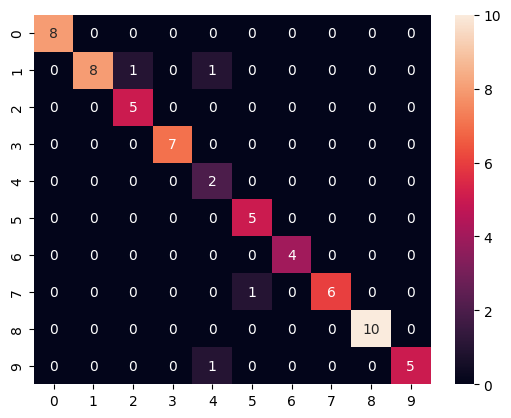

In [ ]:
cm = confusion_matrix(y_true, y_pred)
seaborn.heatmap(cm, annot=True, fmt="d")

In [ ]:
model_vgg16 = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
model_vgg16.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_vgg16.trainable = False

In [ ]:
x = Flatten()(model_vgg16.output)
prediction = Dense(10, activation='softmax')(x)
model_finetune = Model(inputs=model_vgg16.input, outputs=prediction)

In [ ]:
model_finetune.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer='Adam',
    metrics=['accuracy']
    )

In [ ]:
finetune_result = model_finetune.fit(
    ds_train,
    epochs=EPOCHS - 15,
    validation_data=ds_val
)

Epoch 1/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 37s 103ms/step - accuracy: 0.6510 - loss: 9.9064 - val_accuracy: 0.8000 - val_loss: 7.4485
Epoch 2/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 87ms/step - accuracy: 0.9381 - loss: 1.4011 - val_accuracy: 0.7990 - val_loss: 9.6370
Epoch 3/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 87ms/step - accuracy: 0.9595 - loss: 0.9365 - val_accuracy: 0.8450 - val_loss: 8.4119
Epoch 4/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 87ms/step - accuracy: 0.9631 - loss: 0.8196 - val_accuracy: 0.8470 - val_loss: 9.9847
Epoch 5/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 87ms/step - accuracy: 0.9812 - loss: 0.4233 - val_accuracy: 0.8450 - val_loss: 8.4220
Epoch 6/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 87ms/step - accuracy: 0.9749 - loss: 0.6255 - val_accuracy: 0.8210 - val_loss: 12.5402
Epoch 7/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 87ms/step - accuracy: 0.9778 - loss: 0.6529 - val_accuracy: 0.8470 - val_loss: 10.1645
Epoch 8/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 87ms/step - accuracy: 0.9833 - loss: 0.4060

In [ ]:
ftm_train_acc = finetune_result.history['accuracy']
ftm_val_acc = finetune_result.history['val_accuracy']

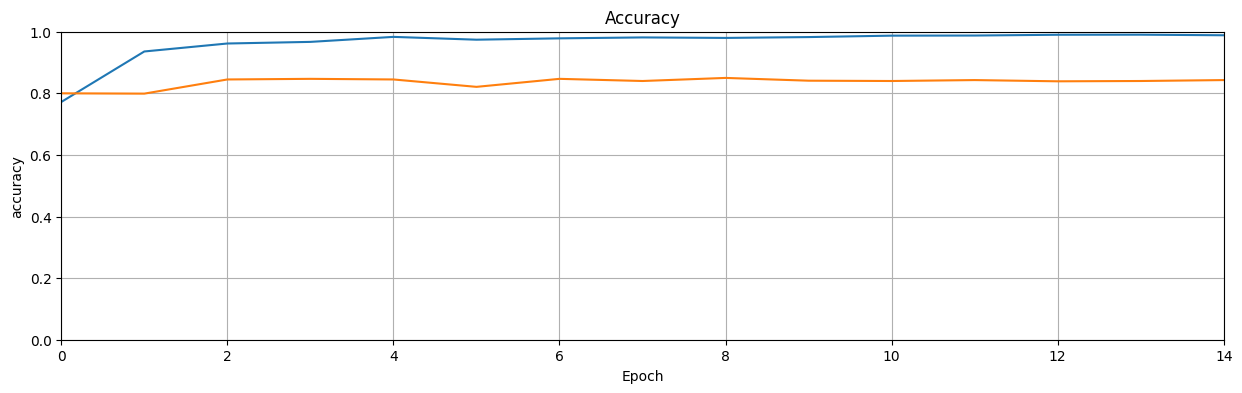

In [ ]:
fig, ax = plt.subplots(figsize=(15, 4))
for idx, metric in enumerate([ftm_train_acc, ftm_val_acc]):
  ax.plot(metric)
plt.title('Accuracy')
plt.xlabel("Epoch")
plt.ylabel("accuracy")
plt.xlim([0, EPOCHS - 16])
plt.ylim([0.0, 1.0])
plt.grid(True)